In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

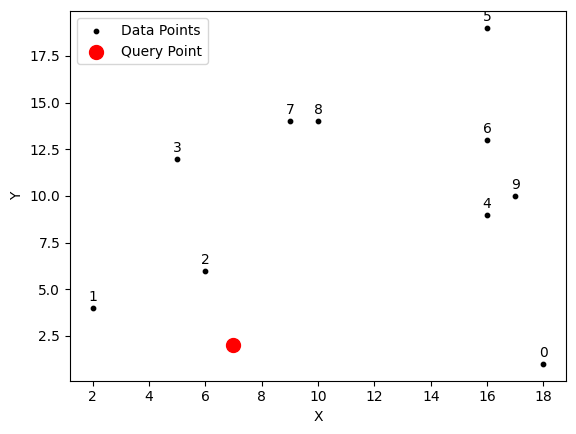

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1975)
data_points = np.random.randint(1, 21, size=(10, 2))
query_point = np.random.randint(1, 21, size=2)

def plot_dataset(data, query):
    plt.scatter(data[:, 0], data[:, 1], color='black', s=10, label='Data Points')
    plt.scatter(query[0], query[1], color='red', marker='o', s=100, label='Query Point')
    for i, txt in enumerate(range(len(data))):
        plt.annotate(txt, (data[i][0], data[i][1]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

plot_dataset(data_points, query_point)
plt.show()



# Naive Approach #

In [7]:
def naive_knn(data, query, k):
    d=[np.linalg.norm(query-point) for point in data]
    i=np.argsort(d)[:k]
    sd=np.sort(d)[:k]
    return i


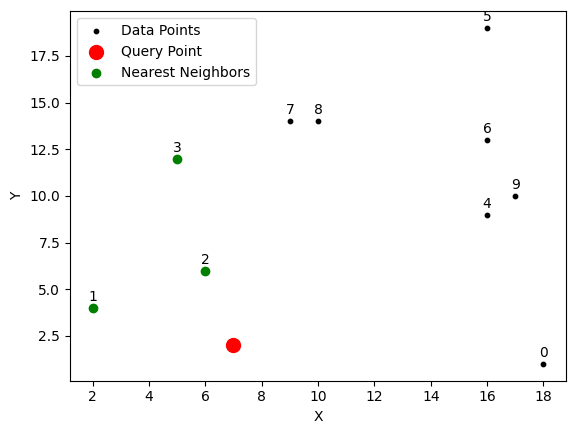

In [8]:
indices=naive_knn(data_points,query_point,3)
k_neighbours=data_points[indices]
plot_dataset(data_points,query_point)
plt.scatter(k_neighbours[:,0],k_neighbours[:,1],color='green',label='Nearest Neighbors')
plt.legend()
plt.show()

# KD tree

In [9]:
class KDNode:
    def __init__(self, split, leaf_points=None, left=None, right=None):
        self.leaf_points = leaf_points
        self.split = split
        self.left = left
        self.right = right

def build_kdtree(points, min_points, depth=0):
    if len(points) <= min_points:
        return KDNode(split=None, leaf_points=points)

    dim = data_points.shape[1]
    axis = depth % dim
    points = sorted(points, key=lambda x: x[axis])
    median = len(points) // 2

    return KDNode(
        points[median],
        leaf_points=None,
        left=build_kdtree(points[:median], min_points, depth + 1),
        right=build_kdtree(points[median + 1:], min_points, depth + 1)
    )

def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def knn_search(node, target, k, data, depth=0):

    dim = len(target)
    while node.left is not None:
        axis = depth % dim
        if target[axis] < node.split[axis]:
            node = node.left
            depth += 1
        else:
            node = node.right
            depth += 1

    subset = node.leaf_points
    distances = {tuple(i): distance(target, i) for i in subset}  # Convert array to tuple
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    k_neighbors = sorted_distances[:k]

    return k_neighbors

kdtree = build_kdtree(data_points, min_points=3)
k_neighbors = knn_search(kdtree, query_point, 3, data_points)
print("Nearest neighbors:", k_neighbors)


Nearest neighbors: [((6, 6), 4.123105625617661), ((2, 4), 5.385164807134504)]


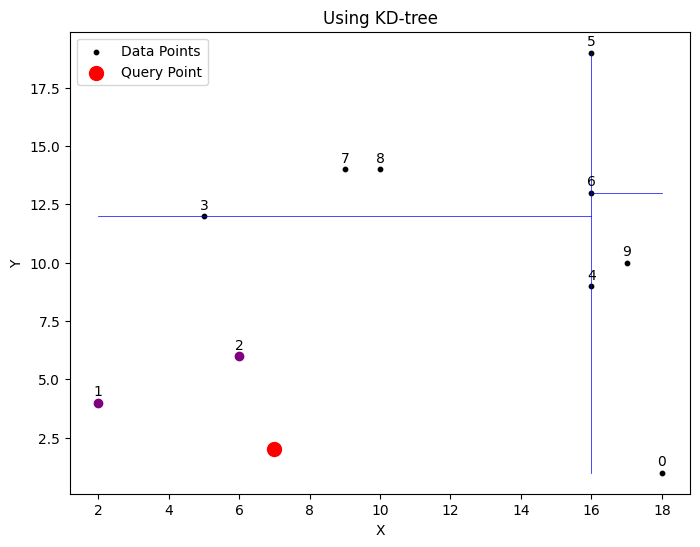

In [10]:
import matplotlib.pyplot as plt

def plot_kdtree(node, xmin, xmax, ymin, ymax, depth=0):
    if node.left is None:
        return

    dim = len(node.split)
    axis = depth % dim
    split_value = node.split[axis]

    if axis == 0:
        plt.plot([split_value, split_value], [ymin, ymax], color='blue', linestyle='-', linewidth=0.5)
        plot_kdtree(node.left, xmin, split_value, ymin, ymax, depth + 1)
        plot_kdtree(node.right, split_value, xmax, ymin, ymax, depth + 1)
    else:
        plt.plot([xmin, xmax], [split_value, split_value], color='blue', linestyle='-', linewidth=0.5)
        plot_kdtree(node.left, xmin, xmax, ymin, split_value, depth + 1)
        plot_kdtree(node.right, xmin, xmax, split_value, ymax, depth + 1)

plt.figure(figsize=(8, 6))
plot_dataset(data_points, query_point)
nearest_neighbor_pts = np.array([neighbor[0] for neighbor in k_neighbors])
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='purple', label='Nearest Neighbors')
plot_kdtree(kdtree, np.min(data_points[:, 0]), np.max(data_points[:, 0]), np.min(data_points[:, 1]), np.max(data_points[:, 1]))
plt.title('Using KD-tree')
plt.show()


# LSH

Approximate Nearest Neighbors: [0, 4, 9]


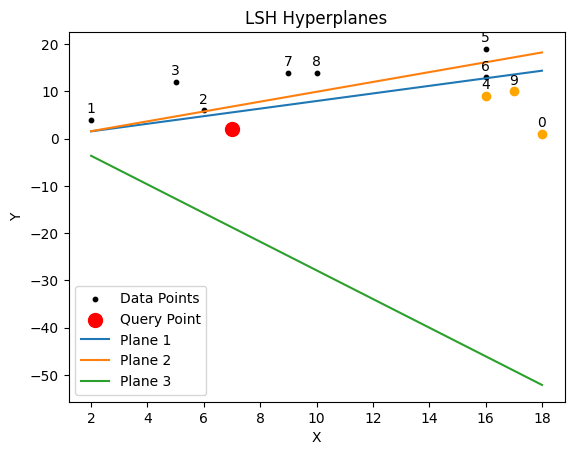

In [11]:
class LSH:
    def __init__(self, num_planes):
        self.num_planes = num_planes
        self.planes = None
        self.buckets = {i: [] for i in range(2**num_planes)}

    def fit(self, points):
        np.random.seed(8)
        self.planes = np.random.randn(points.shape[1] + 1, self.num_planes)
        points_aug = np.hstack([np.ones((points.shape[0], 1)), points])
        hash_codes = (points_aug @ self.planes > 0).astype(int)
        
        for i, code in enumerate(hash_codes):
            bucket_id = int(''.join(map(str, code)), 2)
            self.buckets[bucket_id].append(i)

    def search(self, query, points, k):
        query_aug = np.hstack([[1], query])
        query_code = (query_aug @ self.planes > 0).astype(int)
        bucket_id = int(''.join(map(str, query_code)), 2)
        candidates = self.buckets[bucket_id]
        
        distances = [np.linalg.norm(query - points[j]) for j in candidates]
        sorted_indices = np.argsort(distances)[:k]
        
        return [candidates[j] for j in sorted_indices]

    def show_planes(self, points, query):
        plot_dataset(points, query)
        for i in range(self.num_planes):
            x = np.array([min(points[:, 0]), max(points[:, 0])])
            y = (-self.planes[0, i] - self.planes[1, i] * x) / self.planes[2, i]
            plt.plot(x, y, label=f'Plane {i+1}')
        
        plt.legend()
        plt.title('LSH Hyperplanes')

lsh = LSH(num_planes=3)
lsh.fit(data_points)
k = 3
nearest = lsh.search(query_point, data_points, k)
print("Approximate Nearest Neighbors:", nearest)
nearest_points = data_points[nearest]
lsh.show_planes(data_points, query_point)
plt.scatter(nearest_points[:, 0], nearest_points[:, 1], color='orange', label='Nearest Neighbors')
plt.show()


In [12]:
import tracemalloc
import time
import numpy as np
import matplotlib.pyplot as plt

def evaluate_metrics(data_size, num_dims, k, method):
    data = np.random.rand(data_size, num_dims)
    query = np.random.rand(1, num_dims)

    tracemalloc.start()
    if method == 'kdtree':
        start_train = time.time()
        tree = build_kdtree(data, min_points=50)
        end_train = time.time()

        start_test = time.time()
        nearest_neighbors = knn_search(tree, query[0], k, data)
        end_test = time.time()
        train_time = end_train - start_train

    elif method == 'lsh':
        start_train = time.time()
        lsh = LSH(num_planes=10)
        lsh.fit(data)
        end_train = time.time()

        start_test = time.time()
        nearest_neighbors = lsh.search(query[0], data, k)
        end_test = time.time()
        train_time = end_train - start_train

    elif method == 'naive':
        train_time = 0  # No training step for naive search
        start_test = time.time()
        nearest_neighbors = naive_knn(data, query, k)
        end_test = time.time()

    test_time = end_test - start_test
    _, peak_memory = tracemalloc.get_traced_memory()
    memory_usage = peak_memory / 1024  # Convert to KB
    tracemalloc.stop()

    return train_time, test_time, memory_usage

data_size = 10000
num_dims = 10
k = 3

print(f"Print train timing, test timing, and memory usage on Performance for {data_size} samples, {num_dims} dimensions, {k} nearest neighbors:")
print("Naive KNN:")
print(evaluate_metrics(data_size, num_dims, k, 'naive'))
print("KD Tree:")
print(evaluate_metrics(data_size, num_dims, k, 'kdtree'))
print("LSH:")
print(evaluate_metrics(data_size, num_dims, k, 'lsh'))


Print train timing, test timing, and memory usage on Performance for 10000 samples, 10 dimensions, 3 nearest neighbors:
Naive KNN:
(0, 0.14838123321533203, 556.3359375)
KD Tree:
(0.13811087608337402, 0.0011327266693115234, 1560.765625)
LSH:
(0.3651759624481201, 0.01147150993347168, 2102.9345703125)


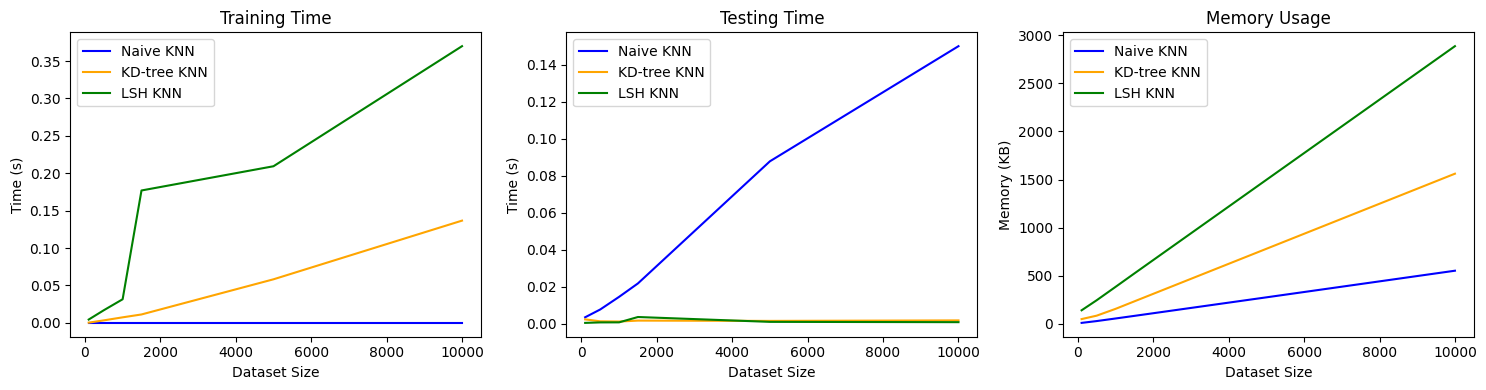

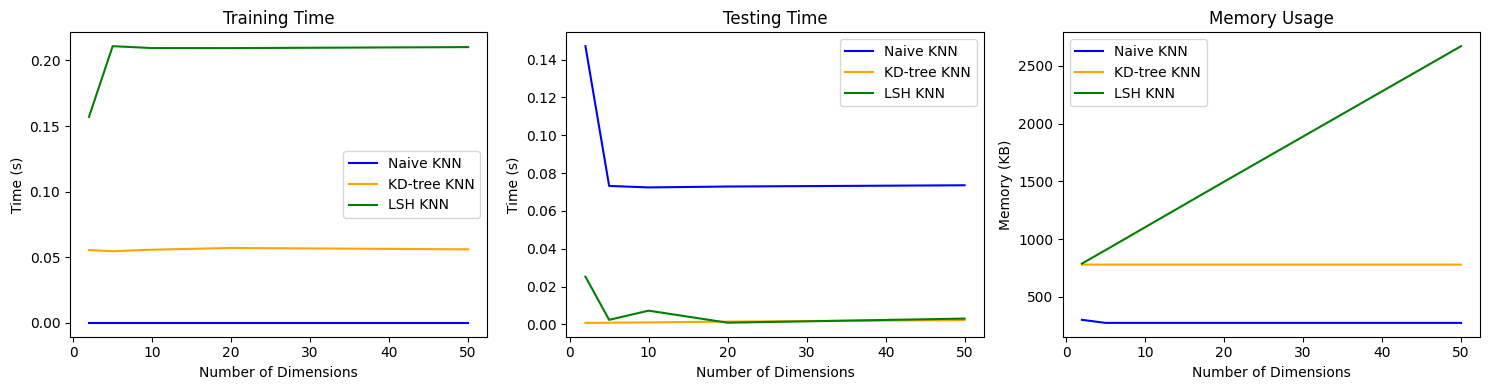

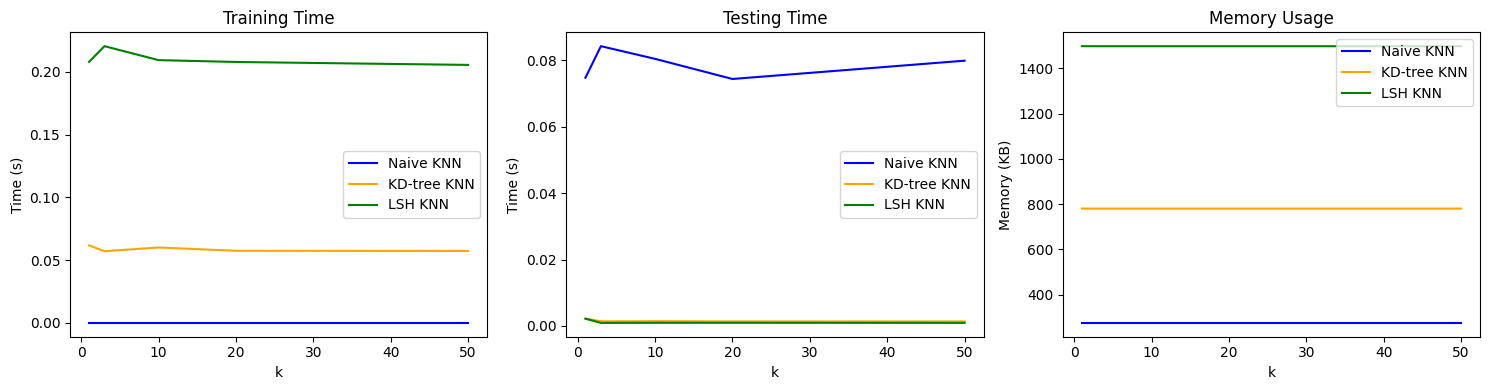

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(xlabel, sizes, train_naive, test_naive, mem_naive,
                 train_kdtree, test_kdtree, mem_kdtree,
                 train_lsh, test_lsh, mem_lsh):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(sizes, train_naive, label="Naive KNN", color='blue')
    axes[0].plot(sizes, train_kdtree, label="KD-tree KNN", color='orange')
    axes[0].plot(sizes, train_lsh, label="LSH KNN", color='green')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel("Time (s)")
    axes[0].set_title("Training Time")
    axes[0].legend()

    axes[1].plot(sizes, test_naive, label="Naive KNN", color='blue')
    axes[1].plot(sizes, test_kdtree, label="KD-tree KNN", color='orange')
    axes[1].plot(sizes, test_lsh, label="LSH KNN", color='green')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel("Time (s)")
    axes[1].set_title("Testing Time")
    axes[1].legend()

    axes[2].plot(sizes, mem_naive, label="Naive KNN", color='blue')
    axes[2].plot(sizes, mem_kdtree, label="KD-tree KNN", color='orange')
    axes[2].plot(sizes, mem_lsh, label="LSH KNN", color='green')
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel("Memory (KB)")
    axes[2].set_title("Memory Usage")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

dataset_sizes = [100, 500, 1000, 1500, 5000, 10000]
train_naive, train_kdtree, train_lsh = [], [], []
test_naive, test_kdtree, test_lsh = [], [], []
mem_naive, mem_kdtree, mem_lsh = [], [], []

for size in dataset_sizes:
    train_time, test_time, memory = evaluate_metrics(size, 20, 5, 'naive')
    train_naive.append(train_time)
    test_naive.append(test_time)
    mem_naive.append(memory)

    train_time, test_time, memory = evaluate_metrics(size, 20, 5, 'kdtree')
    train_kdtree.append(train_time)
    test_kdtree.append(test_time)
    mem_kdtree.append(memory)

    train_time, test_time, memory = evaluate_metrics(size, 20, 5, 'lsh')
    train_lsh.append(train_time)
    test_lsh.append(test_time)
    mem_lsh.append(memory)

plot_metrics('Dataset Size', dataset_sizes, train_naive, test_naive, mem_naive,
             train_kdtree, test_kdtree, mem_kdtree,
             train_lsh, test_lsh, mem_lsh)

dimensions = [2, 5, 10, 20, 50]
train_naive, train_kdtree, train_lsh = [], [], []
test_naive, test_kdtree, test_lsh = [], [], []
mem_naive, mem_kdtree, mem_lsh = [], [], []

for dim in dimensions:
    train_time, test_time, memory = evaluate_metrics(5000, dim, 5, 'naive')
    train_naive.append(train_time)
    test_naive.append(test_time)
    mem_naive.append(memory)

    train_time, test_time, memory = evaluate_metrics(5000, dim, 5, 'kdtree')
    train_kdtree.append(train_time)
    test_kdtree.append(test_time)
    mem_kdtree.append(memory)

    train_time, test_time, memory = evaluate_metrics(5000, dim, 5, 'lsh')
    train_lsh.append(train_time)
    test_lsh.append(test_time)
    mem_lsh.append(memory)

plot_metrics('Number of Dimensions', dimensions, train_naive, test_naive, mem_naive,
             train_kdtree, test_kdtree, mem_kdtree,
             train_lsh, test_lsh, mem_lsh)

k_values = [1, 3, 10, 20, 50]
train_naive, train_kdtree, train_lsh = [], [], []
test_naive, test_kdtree, test_lsh = [], [], []
mem_naive, mem_kdtree, mem_lsh = [], [], []

for k in k_values:
    train_time, test_time, memory = evaluate_metrics(5000, 20, k, 'naive')
    train_naive.append(train_time)
    test_naive.append(test_time)
    mem_naive.append(memory)

    train_time, test_time, memory = evaluate_metrics(5000, 20, k, 'kdtree')
    train_kdtree.append(train_time)
    test_kdtree.append(test_time)
    mem_kdtree.append(memory)

    train_time, test_time, memory = evaluate_metrics(5000, 20, k, 'lsh')
    train_lsh.append(train_time)
    test_lsh.append(test_time)
    mem_lsh.append(memory)

plot_metrics('k', k_values, train_naive, test_naive, mem_naive,
             train_kdtree, test_kdtree, mem_kdtree,
             train_lsh, test_lsh, mem_lsh)


| KNN Variant | Training Time Complexity     | Testing Time Complexity                    |
|-------------|------------------------------|--------------------------------------------|
| Naive KNN   | No training (O(1))           | O(N * D)                                   |
| KD-tree KNN |  O(N log^2 N)                | O(log N + DS) but D,S very less weighted   |
| LSH KNN     |  O(NDP)                      | O(D * P + DP/2^n)                          |


# For varying numbers of datapoints

### 1. **Training Time Analysis**
- **Naive KNN (Blue)**: The training time for the naive KNN remains negligible as it doesn’t involve any preprocessing or data structure building—just storing the dataset.
- **KD-tree KNN (Orange)**: The KD-tree shows a moderate increase in training time as the dataset size grows due to the need for building a tree structure.
- **LSH KNN (Green)**: The LSH (Locality-Sensitive Hashing) approach has the highest training time, as creating hash tables and distributing data points among them is computationally intensive.

### 2. **Testing Time Analysis**
- **Naive KNN (Blue)**: The naive version has a testing time that scales linearly with the dataset size, as it must compute distances to all points for each query.
- **KD-tree KNN (Orange)**: KD-tree has efficient querying, leading to significantly lower testing time, which does not increase as sharply as the naive approach. This is due to its efficient partitioning of space.
- **LSH KNN (Green)**: LSH also shows low testing time since it reduces the number of candidate points to check through hash buckets, but its performance might vary based on the hash function's effectiveness.

### 3. **Memory Usage Analysis**
- **Naive KNN (Blue)**: This variant has the lowest memory usage, as it only requires storing the dataset without any additional structures.
- **KD-tree KNN (Orange)**: Requires more memory than naive KNN due to the tree structure storing node relationships.
- **LSH KNN (Green)**: Consumes the most memory, as multiple hash tables and buckets need to be maintained to support efficient lookup.


# For varying numbers of dimensions

### 1. **Training Time Analysis**
- **Naive KNN (Blue)**: The training time remains nearly zero regardless of the number of dimensions because no preprocessing is needed for this approach.
- **KD-tree KNN (Orange)**: The training time stays relatively consistent even as the number of dimensions increases, but it may slightly decrease due to dimensional splitting not being as effective in higher dimensions.
- **LSH KNN (Green)**: LSH maintains a higher training time compared to KD-tree and naive KNN, but it is fairly stable across different dimensionalities. This stability suggests that the hash table construction's complexity does not significantly change with more dimensions, though the performance may be impacted by hash function properties.

### 2. **Testing Time Analysis**
- **Naive KNN (Blue)**: The testing time for naive KNN is consistently high across dimensions, as each query involves comparing the distance to all points regardless of dimensionality.
- **KD-tree KNN (Orange)**: Testing time remains low for lower dimensions but can be impacted as the dimensions increase due to the "curse of dimensionality," which reduces the tree's efficiency.
- **LSH KNN (Green)**: The testing time for LSH remains relatively low and stable across different dimensions, which highlights its effectiveness for approximate nearest neighbor searches even in higher dimensions.

### 3. **Memory Usage Analysis**
- **Naive KNN (Blue)**: Memory usage remains minimal and constant because it only stores the dataset without additional structures.
- **KD-tree KNN (Orange)**: Memory usage is consistent across different dimensions as the structure does not expand significantly with dimension increases, although splitting planes are still used.
- **LSH KNN (Green)**: The memory usage for LSH increases linearly with the number of dimensions. This is expected due to the additional hash tables and higher-dimensional buckets needed for approximate searches.


# For varying numbers of K


### 1. **Training Time Analysis**
- **Naive KNN (Blue)**: The training time for naive KNN is negligible and does not change with \( k \) since no preprocessing is done during training.
- **KD-tree KNN (Orange)**: The training time is almost constant across different \( k \) values, as the tree structure is built independently of \( k \).
- **LSH KNN (Green)**: The training time remains constant across varying \( k \) values since LSH relies on hash table construction, which doesn't depend on \( k \).

### 2. **Testing Time Analysis**
- **Naive KNN (Blue)**: The testing time is higher and remains stable as \( k \) changes, indicating that the exhaustive search method is not affected by \( k \) directly, but rather by the dataset size.
- **KD-tree KNN (Orange)**: Testing time for KD-tree KNN remains very low and stable with different \( k \) values due to efficient tree traversal.
- **LSH KNN (Green)**: The testing time is also low and fairly consistent across \( k \) values, showcasing the method's efficiency in finding approximate neighbors irrespective of \( k \).

### 3. **Memory Usage Analysis**
- **Naive KNN (Blue)**: Memory usage is minimal and constant since it only stores the dataset.
- **KD-tree KNN (Orange)**: Memory usage remains stable as \( k \) changes, as the tree structure once built does not vary with \( k \).
- **LSH KNN (Green)**: Memory usage is the highest among the three and constant across different \( k \) values due to the fixed hash table storage requirements.
